In [3]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
import deepretina.visualizations as viz
from deepretina.preprocessing import datagen, loadexpt
from deepretina.utils import rolling_window
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


# Load natural scenes CNN and white noise LN

In [2]:
architecture_filename = 'architecture.json'
naturalscenes_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-07 16.52.44 convnet/')
naturalscenes_weight_filename = 'epoch038_iter02700_weights.h5' # .53 cc on held-out
ln_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-11-08 04.41.18 LN/')
ln_weight_filename = 'epoch010_iter00750_weights.h5' # .468 cc on held-out

In [3]:
naturalscenes_architecture_data = open(naturalscenes_data_dir + architecture_filename, 'r')
naturalscenes_architecture_string = naturalscenes_architecture_data.read()
naturalscenes_model = model_from_json(naturalscenes_architecture_string)
naturalscenes_model.load_weights(naturalscenes_data_dir + naturalscenes_weight_filename)

In [4]:
ln_architecture_data = open(ln_data_dir + architecture_filename, 'r')
ln_architecture_string = ln_architecture_data.read()
ln_model = model_from_json(ln_architecture_string)
ln_model.load_weights(ln_data_dir + ln_weight_filename)

In [7]:
nsamples = 1000
batch_size = 50
cnn_sta = np.zeros((40,50,50), dtype='float32')
for iteration in range(nsamples):
    sample = np.random.randn(batch_size, 40, 50, 50).astype('float32')
    
    cnn_response = naturalscenes_model.predict(sample)
    
    cnn_sta_subset = np.tensordot(cnn_response.T, sample, axes=1)
    cnn_sta += cnn_sta_subset[0]

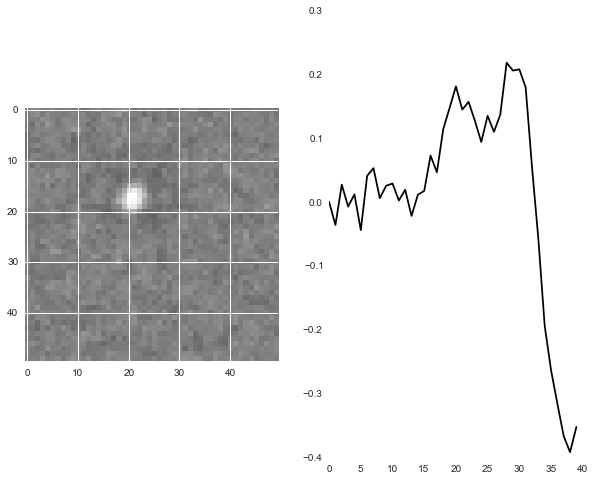

In [8]:
sp, tm = ft.decompose(cnn_sta)
plt.subplot(121)
plt.imshow(sp, clim=[-np.max(abs(sp)), np.max(abs(sp))])
plt.subplot(122)
plt.plot(tm, 'k')

In [9]:
cnn_sta.shape

(40, 50, 50)

In [ ]:
cnn_stc = np.outer(cnn_sta, cnn_sta.T)

In [ ]:
cnn_stc.shape

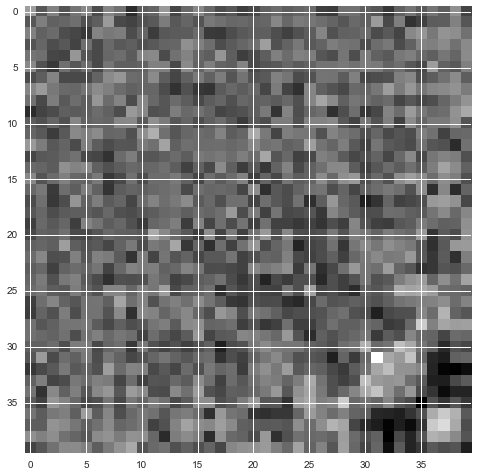

In [13]:
plt.imshow(cnn_stc)

In [4]:
architecture_filename = 'architecture.json'
whitenoise_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-08 15.42.33 convnet/')
whitenoise_weight_filename = 'epoch018_iter01300_weights.h5' # .63 cc on held-out
naturalscenes_data_dir = expanduser('~/Dropbox/deep-retina/saved/lenna.salamander/2015-11-07 16.52.44 convnet/')
naturalscenes_weight_filename = 'epoch038_iter02700_weights.h5' # .53 cc on held-out

In [5]:
whitenoise_architecture_data = open(whitenoise_data_dir + architecture_filename, 'r')
whitenoise_architecture_string = whitenoise_architecture_data.read()
whitenoise_model = model_from_json(whitenoise_architecture_string)
whitenoise_model.load_weights(whitenoise_data_dir + whitenoise_weight_filename)

In [7]:
naturalscenes_architecture_data = open(naturalscenes_data_dir + architecture_filename, 'r')
naturalscenes_architecture_string = naturalscenes_architecture_data.read()
naturalscenes_model = model_from_json(naturalscenes_architecture_string)
naturalscenes_model.load_weights(naturalscenes_data_dir + naturalscenes_weight_filename)

In [8]:
nsamples = 1000
batch_size = 50
whitenoise_cnn_sta = np.zeros((40,50,50), dtype='float32')
naturalscenes_cnn_sta = np.zeros((40,50,50), dtype='float32')
for iteration in range(nsamples):
    sample = np.random.randn(batch_size, 40, 50, 50).astype('float32')
    
    whitenoise_cnn_response = whitenoise_model.predict(sample)
    naturalscenes_cnn_response = naturalscenes_model.predict(sample)
    
    whitenoise_cnn_sta_subset = np.tensordot(whitenoise_cnn_response.T, sample, axes=1)
    naturalscenes_cnn_sta_subset = np.tensordot(naturalscenes_cnn_response.T, sample, axes=1)
    whitenoise_cnn_sta += whitenoise_cnn_sta_subset[0]
    naturalscenes_cnn_sta += naturalscenes_cnn_sta_subset[0]

In [9]:
sp_whitenoise, tm_whitenoise = ft.decompose(whitenoise_cnn_sta)
sp_naturalscenes, tm_naturalscenes = ft.decompose(naturalscenes_cnn_sta)

In [10]:
whitenoise_abs_max = np.max(abs(sp_whitenoise))
naturalscenes_abs_max = np.max(abs(sp_naturalscenes))

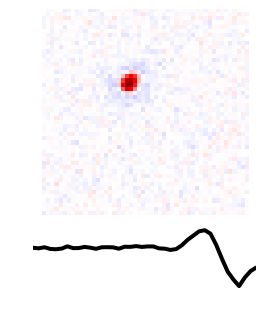

In [36]:
fig = plt.gcf()
fig.set_size_inches((4,5))

ax = plt.subplot2grid((4, 1), (0,0), rowspan=3)
ax.imshow(sp_whitenoise, interpolation='nearest', cmap='seismic', clim=[-whitenoise_abs_max, whitenoise_abs_max]) #, clim=[np.min(W0), np.max(W0)])
plt.grid('off')
plt.axis('off')

ax = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax.plot(np.linspace(0,400,40), tm_whitenoise, 'k', linewidth=4)
plt.grid('off')
plt.axis('off')
plt.savefig('Whitenoise_CNN_Total_RF_seismic.png', dpi=500)

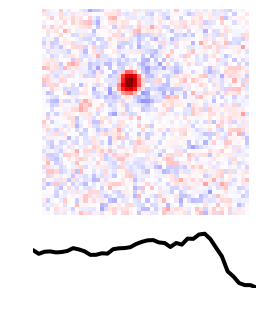

In [35]:
fig = plt.gcf()
fig.set_size_inches((4,5))

ax = plt.subplot2grid((4, 1), (0,0), rowspan=3)
ax.imshow(sp_naturalscenes, interpolation='nearest', cmap='seismic', clim=[-naturalscenes_abs_max, naturalscenes_abs_max]) #, clim=[np.min(W0), np.max(W0)])
plt.grid('off')
plt.axis('off')

ax = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
ax.plot(np.linspace(0,400,40), tm_naturalscenes, 'k', linewidth=4)
plt.grid('off')
plt.axis('off')
plt.savefig('Naturalscenes_CNN_Total_RF_seismic.png', dpi=500)

In [37]:
naturalscenes_weights = h5py.File(naturalscenes_data_dir + naturalscenes_weight_filename, 'r')
list(naturalscenes_weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

In [38]:
whitenoise_weights = h5py.File(whitenoise_data_dir + whitenoise_weight_filename, 'r')
list(whitenoise_weights)

[u'layer_0', u'layer_1', u'layer_2', u'layer_3', u'layer_4']

In [39]:
whitenoise_W0 = whitenoise_weights['layer_0']['param_0']
naturalscenes_W0 = naturalscenes_weights['layer_0']['param_0']

In [41]:
whitenoise_spatial_profiles = [ft.decompose(i)[0] for i in whitenoise_W0]
naturalscenes_spatial_profiles = [ft.decompose(i)[0] for i in naturalscenes_W0]

In [43]:
whitenoise_abs_max = np.max(abs(np.array(whitenoise_spatial_profiles)))
naturalscenes_abs_max = np.max(abs(np.array(naturalscenes_spatial_profiles)))

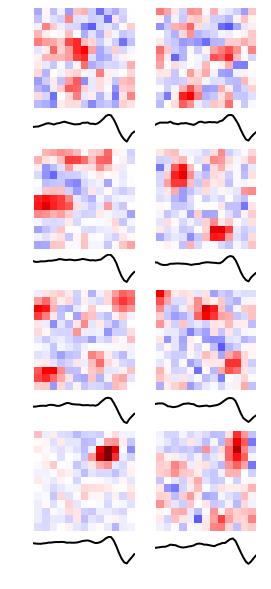

In [47]:
nfilters = whitenoise_W0.shape[0]

fig = plt.gcf()
fig.set_size_inches((4,10))
plt.title('Whitenoise Affine STAs', fontsize=20)
num_cols = int(np.sqrt(nfilters))
num_rows = int(np.ceil(nfilters/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(whitenoise_W0[plt_idx-1])
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='seismic', clim=[-whitenoise_abs_max, whitenoise_abs_max]) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')
plt.savefig('Whitenoise_Conv_filters_seismic.png', dpi=500)

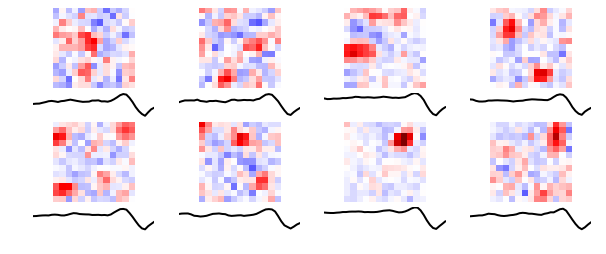

In [64]:
nfilters = whitenoise_W0.shape[0]

fig = plt.gcf()
fig.set_size_inches((10,4))
num_rows = int(np.sqrt(nfilters))
num_cols = int(np.ceil(nfilters/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(whitenoise_W0[plt_idx-1])
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='seismic', clim=[-whitenoise_abs_max, whitenoise_abs_max]) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')
plt.savefig('Whitenoise_Conv_filters_seismic.png', dpi=500)

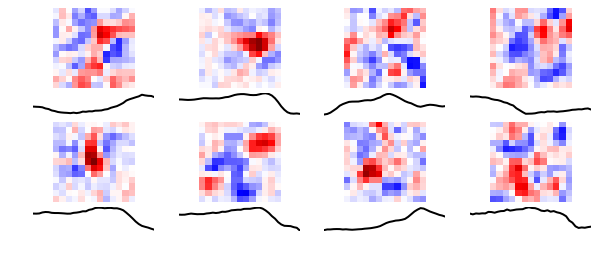

In [62]:
nfilters = whitenoise_W0.shape[0]

fig = plt.gcf()
fig.set_size_inches((10,4))
num_rows = int(np.sqrt(nfilters))
num_cols = int(np.ceil(nfilters/num_cols))
idxs = range(num_cols)
for x in range(num_cols):
    for y in range(num_rows):
        plt_idx = y * num_cols + x + 1
        spatial,temporal = ft.decompose(naturalscenes_W0[plt_idx-1])
        #plt.subplot(num_rows, num_cols, plt_idx)
        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y, x), rowspan=3)
        ax.imshow(spatial, interpolation='nearest', cmap='seismic', clim=[-naturalscenes_abs_max, naturalscenes_abs_max]) #, clim=[np.min(W0), np.max(W0)])
        plt.grid('off')
        plt.axis('off')

        ax = plt.subplot2grid((num_rows*4, num_cols), (4*y+3, x), rowspan=1)
        ax.plot(np.linspace(0,400,40), temporal, 'k', linewidth=2)
        plt.grid('off')
        plt.axis('off')

        
plt.savefig('Naturalscenes_Conv_filters_seismic.png', dpi=500)